In [48]:
import numpy as np
import pandas as pd
import matplotlib as mtl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
import numpy.linalg as nlg
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier


In [49]:
# 读取文件
path_1 = '../resources/Molecular_Descriptor.xlsx'
path_2 = '../resources/ERα_activity.xlsx'
path_3 = '../resources/ADMET.xlsx'
data_descriptor = pd.DataFrame(pd.read_excel(path_1))
data_activity = pd.read_excel(path_2)
data_admet = pd.read_excel(path_3)

## Step1数据预处理
* 检查是否有缺省项，如果有缺省项以上一次出现的值填充缺省项
* 检查是否有重复行或列，如果有则删除重复的行(列)
* 删除方差小于0.0005的列



In [50]:
# TODO 检查是否有缺省项
sum(data_descriptor.isnull().sum())

0

In [51]:
# TODO 检查是否有重复行或列
# 检查是否有重复列
len(data_descriptor.columns) == len(data_descriptor.columns.unique())
# 检查是否有重复行并删除重复行
data_descriptor.duplicated().astype(int).sum()

0

In [52]:
# TODO 删除方差小于0.0005的列
# 获取方差小于0.0005的列索引
# updata @plory
# data_descriptor_final为最终处理好的data_descriptor，其中不存在缺省项且各列方差均大于0.0005
index_columns = []
index = 0
for bool_ in (data_descriptor.var() < 0.0005).tolist():
    if bool_:
        index_columns.append(index)
    index += 1
index_columns = np.array(index_columns).reshape((len(index_columns),))
data_descriptor_final = data_descriptor.drop(axis=1, columns=data_descriptor.columns[index_columns])
data_descriptor_final.head()

C:\Users\piblank\AppData\Local\Temp\ipykernel_81480\1495873923.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  for bool_ in (data_descriptor.var() < 0.0005).tolist():


,SMILES,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,MW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCC3)c4ccc(OCCN5C...,0,-0.2860,0.081796,126.1188,74.170169,12,12,64,31,...,439.218115,64.771680,2.089409,15.471445,8.858910,3.406628,3011,47,4.666,166
1,Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCCCC3)c4ccc(OCCN...,0,-0.8620,0.743044,131.9420,80.357341,12,12,70,33,...,467.249415,68.960024,2.089698,15.486947,8.863774,3.406648,3516,54,5.804,174
2,Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN...,0,0.7296,0.532316,139.9304,74.064997,18,18,62,33,...,463.181729,68.748923,2.083301,18.011114,11.390412,3.406644,3542,52,2.964,176
3,Oc1ccc2O[C@H]([C@@H](CC3CCCCC3)Sc2c1)c4ccc(OCC...,0,-0.3184,0.101379,133.4822,80.357341,12,12,70,33,...,467.249415,68.883696,2.087385,15.468365,8.857943,3.406624,3594,50,6.015,174
4,Oc1ccc2O[C@H]([C@@H](Cc3ccccc3)Sc2c1)c4ccc(OCC...,0,1.3551,1.836296,143.1903,76.356583,18,18,64,33,...,461.202465,68.883696,2.087385,15.468365,8.857943,3.406624,3594,50,4.462,174


## Step2相关性分析、重要性排序、分子描述符选择
* 初步分析部分列值的分布情况

In [53]:
# TODO 初步分析部分列取值的分布情况
# 使用概率密度描绘分布情况
from matplotlib import hatch
"""
p_values = {value:len(data_descriptor_final[data_descriptor_final['nAcid'] == value]) for value in data_descriptor_final['nAcid'].unique()}
plt.bar(x=p_values.keys(), height=p_values.values(), width=0.5, hatch='//', edgecolor='r', linewidth=2, color=[(1-value/sum(p_values.values()), 1-value/sum(p_values.values()), 1-value/sum(p_values.values()))for value in p_values.values()])
plt.show()
values = data_descriptor_final['nAcid']
X = values.ravel()
pds = pd.Series(p_values)
n, bins, patchs = plt.hist(values.ravel(), bins=150, density=True, align='mid')
y = np.exp(-((bins - X.mean()) ** 2) / (2 * X.std() ** 2)) / (X.std() * np.sqrt(2 * np.pi))
# list(pds).plot(kind='kde')
plt.plot(bins, y, 'r-')
plt.show()

"""

"\np_values = {value:len(data_descriptor_final[data_descriptor_final['nAcid'] == value]) for value in data_descriptor_final['nAcid'].unique()}\nplt.bar(x=p_values.keys(), height=p_values.values(), width=0.5, hatch='//', edgecolor='r', linewidth=2, color=[(1-value/sum(p_values.values()), 1-value/sum(p_values.values()), 1-value/sum(p_values.values()))for value in p_values.values()])\nplt.show()\nvalues = data_descriptor_final['nAcid']\nX = values.ravel()\npds = pd.Series(p_values)\nn, bins, patchs = plt.hist(values.ravel(), bins=150, density=True, align='mid')\ny = np.exp(-((bins - X.mean()) ** 2) / (2 * X.std() ** 2)) / (X.std() * np.sqrt(2 * np.pi))\n# list(pds).plot(kind='kde')\nplt.plot(bins, y, 'r-')\nplt.show()\n\n"

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


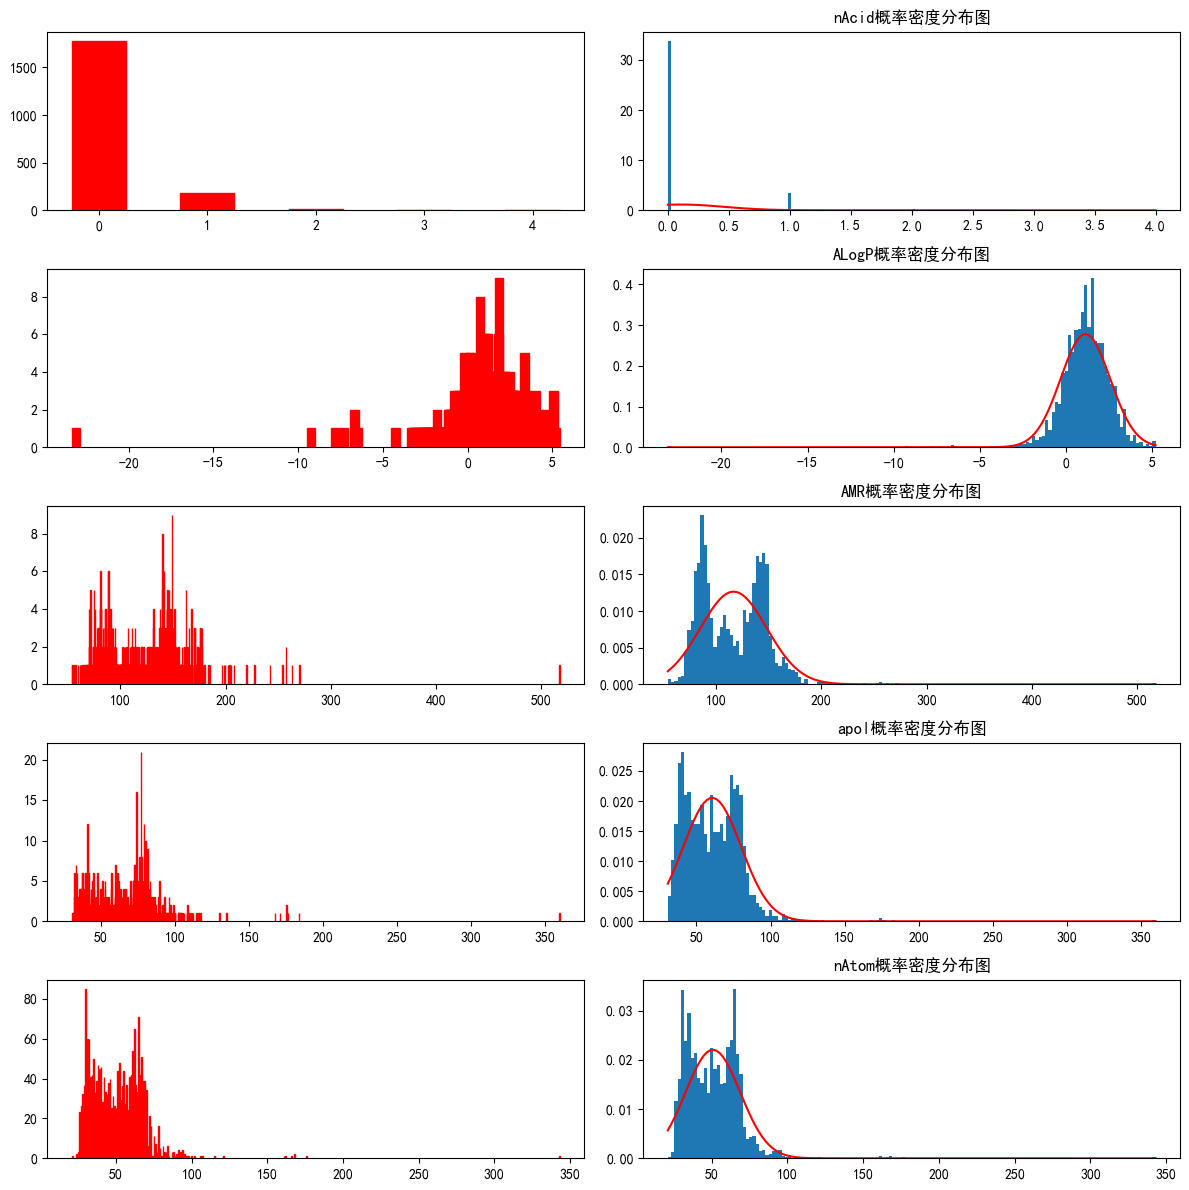

In [54]:
plt.rcParams['font.family'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['figure.dpi'] = 100
columns = ['nAcid', 'ALogP', 'AMR', 'apol', 'nAtom']
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))    # 图坑
print(ax)
fig.patch.set_facecolor('white')
for i in range(len(columns)):
    p_values = {value:len(data_descriptor_final[data_descriptor_final[columns[i]] == value]) for value in data_descriptor_final[columns[i]].unique()}
    ax[i][0].bar(x=list(p_values.keys()), height=p_values.values(), hatch='//', width=0.5, edgecolor='r', color='r')
    values = data_descriptor_final[columns[i]]
    X = values.ravel()
    n, bins, patchs = ax[i][1].hist(values.ravel(), bins=150, density=True, align='mid')
    y = np.exp(-((bins - X.mean()) ** 2) / (2 * X.std() ** 2)) / (X.std() * np.sqrt(2 * np.pi))
    ax[i][1].plot(bins, y, 'r-')
    ax[i][1].set_title(columns[i]+'概率密度分布图')
plt.tight_layout()
plt.show()

通过简单分析可以发现，部分特征取值较为随机，部分特征取值以及概率密度分布有较大重合区间。因此认为部分特征之间具有较强的相关性，也就是认为其对药物活性的贡献可能相关。所以在选择重要性较强的分子描述符的同时，需要考虑已选分子描述符之间是否相关性较强，如果有较强相关性则只能选取其中一个作为选定分子描述符。综上所述，分子描述符的选择需要结合重要性排序以及相关性同时考虑。
因此下面将进行相关性分析与重要性排序的计算。
* 相关性分析
* 重要性排序
* 结合相关性分析数据与重要性排序选择对药物活性影响最大的前20个分子描述符

In [55]:
# TODO 使用随机森林计算各分子描述符对piC50贡献度
df_features = data_descriptor_final.drop(columns='SMILES')
df_y = pd.DataFrame(data_activity['pIC50'], columns=['pIC50'])
forest = RandomForestClassifier(n_estimators=5, random_state=1)
forest.fit(df_features.values, df_y.values.ravel().astype('str'))
# forests.feature_importances_
indices = np.argsort(forest.feature_importances_)[::-1]    # 逆序

In [56]:
data_descriptor_final.columns[1:][indices]

Index(['BCUTc-1h', 'XLogP', 'mindssC', 'ATSc5', 'FMF', 'hmin', 'ETA_EtaP',
       'minHBa', 'minssO', 'ETA_EtaP_B',
       ...
       'SssssPb', 'SddssSe', 'SSm', 'SdssS', 'SsSH', 'nddsN', 'nHsssNHp',
       'SsssP', 'MDEN-11', 'nHtCH'],
      dtype='object', length=482)

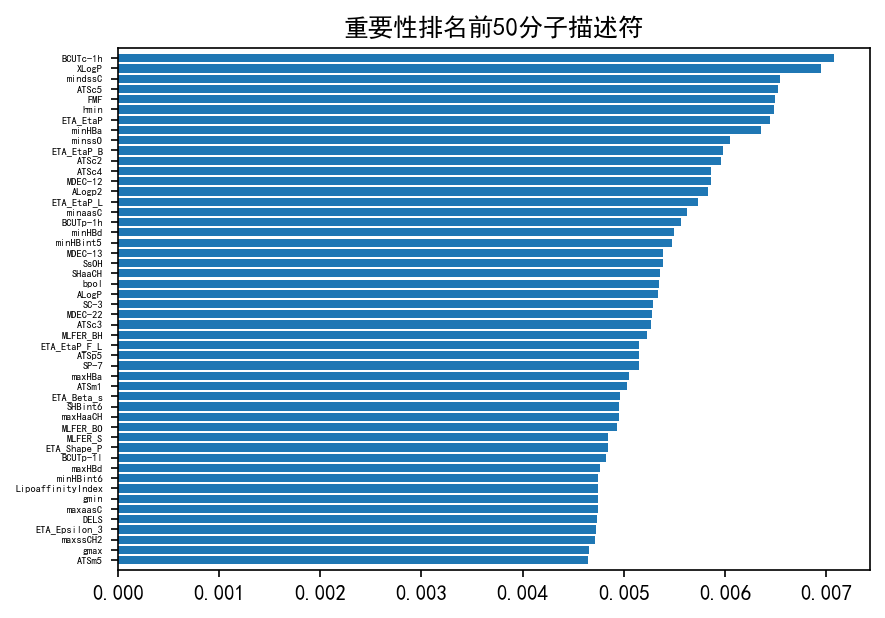

In [57]:
# 按重要性值从大到小以柱状图形式展示前50个分子描述符
plt.rcParams['figure.dpi'] = 150
plt.barh(range(50), forest.feature_importances_[indices][:50][::-1], align='center')
plt.yticks(range(50), data_descriptor_final.columns[1:][indices][:50][::-1], fontsize=5)
plt.ylim([-1, 50])
plt.tight_layout()
plt.title('重要性排名前50分子描述符')
plt.show()

In [69]:
# 以重要性排名顺序重置列顺序
temp_data = data_descriptor_final.drop(columns='SMILES')
temp_data.columns = np.arange(len(temp_data.columns))
temp_data = temp_data[indices]
temp_data.columns = data_descriptor_final.columns[1:][indices]
temp_data.head()


,BCUTc-1h,XLogP,mindssC,ATSc5,FMF,hmin,ETA_EtaP,minHBa,minssO,ETA_EtaP_B,...,SssssPb,SddssSe,SSm,SdssS,SsSH,nddsN,nHsssNHp,SsssP,MDEN-11,nHtCH
0,0.185437,4.666,0.0,-0.080148,0.468750,-0.436065,1.11373,-1.331303,6.050188,0.00500,...,0,0,0,0.0,0.0,0,0,0,0.0,0
1,0.185459,5.804,0.0,-0.080148,0.457143,-0.476881,1.19461,-1.378628,6.083246,0.00469,...,0,0,0,0.0,0.0,0,0,0,0.0,0
2,0.116954,2.964,0.0,-0.059065,0.500000,-0.401857,0.95054,-1.608354,6.020424,0.00791,...,0,0,0,0.0,0.0,0,0,0,0.0,0
3,0.185459,6.015,0.0,-0.079743,0.457143,-0.452506,1.17776,-1.350874,6.071897,0.00520,...,0,0,0,0.0,0.0,0,0,0,0.0,0
4,0.185459,4.462,0.0,-0.069664,0.500000,-0.414507,0.97753,-1.449689,6.046045,0.00520,...,0,0,0,0.0,0.0,0,0,0,0.0,0


In [70]:
# TODO 相关性分析
# 将piC50数据作为label，进行相关系数矩阵计算
temp_data = pd.DataFrame(pd.concat([data_activity['pIC50'], temp_data], axis=1))
temp_data.head()

,pIC50,BCUTc-1h,XLogP,mindssC,ATSc5,FMF,hmin,ETA_EtaP,minHBa,minssO,...,SssssPb,SddssSe,SSm,SdssS,SsSH,nddsN,nHsssNHp,SsssP,MDEN-11,nHtCH
0,8.602060,0.185437,4.666,0.0,-0.080148,0.468750,-0.436065,1.11373,-1.331303,6.050188,...,0,0,0,0.0,0.0,0,0,0,0.0,0
1,8.124939,0.185459,5.804,0.0,-0.080148,0.457143,-0.476881,1.19461,-1.378628,6.083246,...,0,0,0,0.0,0.0,0,0,0,0.0,0
2,8.508638,0.116954,2.964,0.0,-0.059065,0.500000,-0.401857,0.95054,-1.608354,6.020424,...,0,0,0,0.0,0.0,0,0,0,0.0,0
3,8.408935,0.185459,6.015,0.0,-0.079743,0.457143,-0.452506,1.17776,-1.350874,6.071897,...,0,0,0,0.0,0.0,0,0,0,0.0,0
4,8.130768,0.185459,4.462,0.0,-0.069664,0.500000,-0.414507,0.97753,-1.449689,6.046045,...,0,0,0,0.0,0.0,0,0,0,0.0,0


In [65]:
# 未标准化
temp_data_corr = temp_data.corr(method='kendall')
temp_data_corr

,pIC50,pIC50,BCUTc-1h,XLogP,mindssC,ATSc5,FMF,hmin,ETA_EtaP,minHBa,...,SssssPb,SddssSe,SSm,SdssS,SsSH,nddsN,nHsssNHp,SsssP,MDEN-11,nHtCH
pIC50,1.000000,1.000000,-0.233088,0.267875,0.142813,-0.083108,-0.034424,-0.287557,0.207283,-0.052307,...,NaN,NaN,NaN,-0.022148,-0.019452,NaN,NaN,NaN,-0.077408,-0.003876
pIC50,1.000000,1.000000,-0.233088,0.267875,0.142813,-0.083108,-0.034424,-0.287557,0.207283,-0.052307,...,NaN,NaN,NaN,-0.022148,-0.019452,NaN,NaN,NaN,-0.077408,-0.003876
BCUTc-1h,-0.233088,-0.233088,1.000000,-0.200136,-0.464562,0.103446,0.026340,0.044768,-0.135609,-0.112045,...,NaN,NaN,NaN,-0.031121,-0.003598,NaN,NaN,NaN,0.006901,-0.047591
XLogP,0.267875,0.267875,-0.200136,1.000000,0.175055,-0.039194,-0.260218,-0.179604,0.377496,0.072941,...,NaN,NaN,NaN,-0.031385,0.023058,NaN,NaN,NaN,-0.065427,0.016205
mindssC,0.142813,0.142813,-0.464562,0.175055,1.000000,-0.056115,0.015959,-0.048984,0.171555,0.138449,...,NaN,NaN,NaN,-0.004487,0.004487,NaN,NaN,NaN,-0.034379,0.061308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nddsN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
nHsssNHp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
SsssP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
MDEN-11,-0.077408,-0.077408,0.006901,-0.065427,-0.034379,-0.017586,-0.066437,0.005917,0.008120,-0.034832,...,NaN,NaN,NaN,0.002438,-0.002438,NaN,NaN,NaN,1.000000,-0.010095


In [71]:
# 标准化
temp_data_std = scale(temp_data)
temp_data_std = pd.DataFrame(temp_data_std, columns=temp_data.columns)
temp_data_std_corr = temp_data_std.corr(method='kendall')
temp_data_std_corr


,pIC50,BCUTc-1h,XLogP,mindssC,ATSc5,FMF,hmin,ETA_EtaP,minHBa,minssO,...,SssssPb,SddssSe,SSm,SdssS,SsSH,nddsN,nHsssNHp,SsssP,MDEN-11,nHtCH
pIC50,1.000000,-0.233088,0.267875,0.142813,-0.083108,-0.034424,-0.287557,0.207283,-0.052307,0.228507,...,NaN,NaN,NaN,-0.022148,-0.019452,NaN,NaN,NaN,-0.077408,-0.003876
BCUTc-1h,-0.233088,1.000000,-0.200136,-0.464562,0.103446,0.026340,0.044768,-0.135609,-0.112045,-0.072426,...,NaN,NaN,NaN,-0.031121,-0.003598,NaN,NaN,NaN,0.006901,-0.047591
XLogP,0.267875,-0.200136,1.000000,0.175055,-0.039194,-0.260218,-0.179604,0.377496,0.072941,0.149112,...,NaN,NaN,NaN,-0.031385,0.023058,NaN,NaN,NaN,-0.065427,0.016205
mindssC,0.142813,-0.464562,0.175055,1.000000,-0.056115,0.015959,-0.048984,0.171555,0.138449,0.029682,...,NaN,NaN,NaN,-0.004487,0.004487,NaN,NaN,NaN,-0.034379,0.061308
ATSc5,-0.083108,0.103446,-0.039194,-0.056115,1.000000,-0.013492,0.025288,-0.040181,0.126152,-0.078826,...,NaN,NaN,NaN,-0.003888,-0.003372,NaN,NaN,NaN,-0.017586,-0.012152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nddsN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
nHsssNHp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
SsssP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
MDEN-11,-0.077408,0.006901,-0.065427,-0.034379,-0.017586,-0.066437,0.005917,0.008120,-0.034832,-0.043307,...,NaN,NaN,NaN,0.002438,-0.002438,NaN,NaN,NaN,1.000000,-0.010095


In [78]:
temp_data.columns[:50]

Index(['pIC50', 'BCUTc-1h', 'XLogP', 'mindssC', 'ATSc5', 'FMF', 'hmin',
       'ETA_EtaP', 'minHBa', 'minssO', 'ETA_EtaP_B', 'ATSc2', 'ATSc4',
       'MDEC-12', 'ALogp2', 'ETA_EtaP_L', 'minaasC', 'BCUTp-1h', 'minHBd',
       'minHBint5', 'MDEC-13', 'SsOH', 'SHaaCH', 'bpol', 'ALogP', 'SC-3',
       'MDEC-22', 'ATSc3', 'MLFER_BH', 'ETA_EtaP_F_L', 'ATSp5', 'SP-7',
       'maxHBa', 'ATSm1', 'ETA_Beta_s', 'SHBint6', 'maxHaaCH', 'MLFER_BO',
       'MLFER_S', 'ETA_Shape_P', 'BCUTp-1l', 'maxHBd', 'minHBint6',
       'LipoaffinityIndex', 'gmin', 'maxaasC', 'DELS', 'ETA_Epsilon_3',
       'maxssCH2', 'gmax'],
      dtype='object')

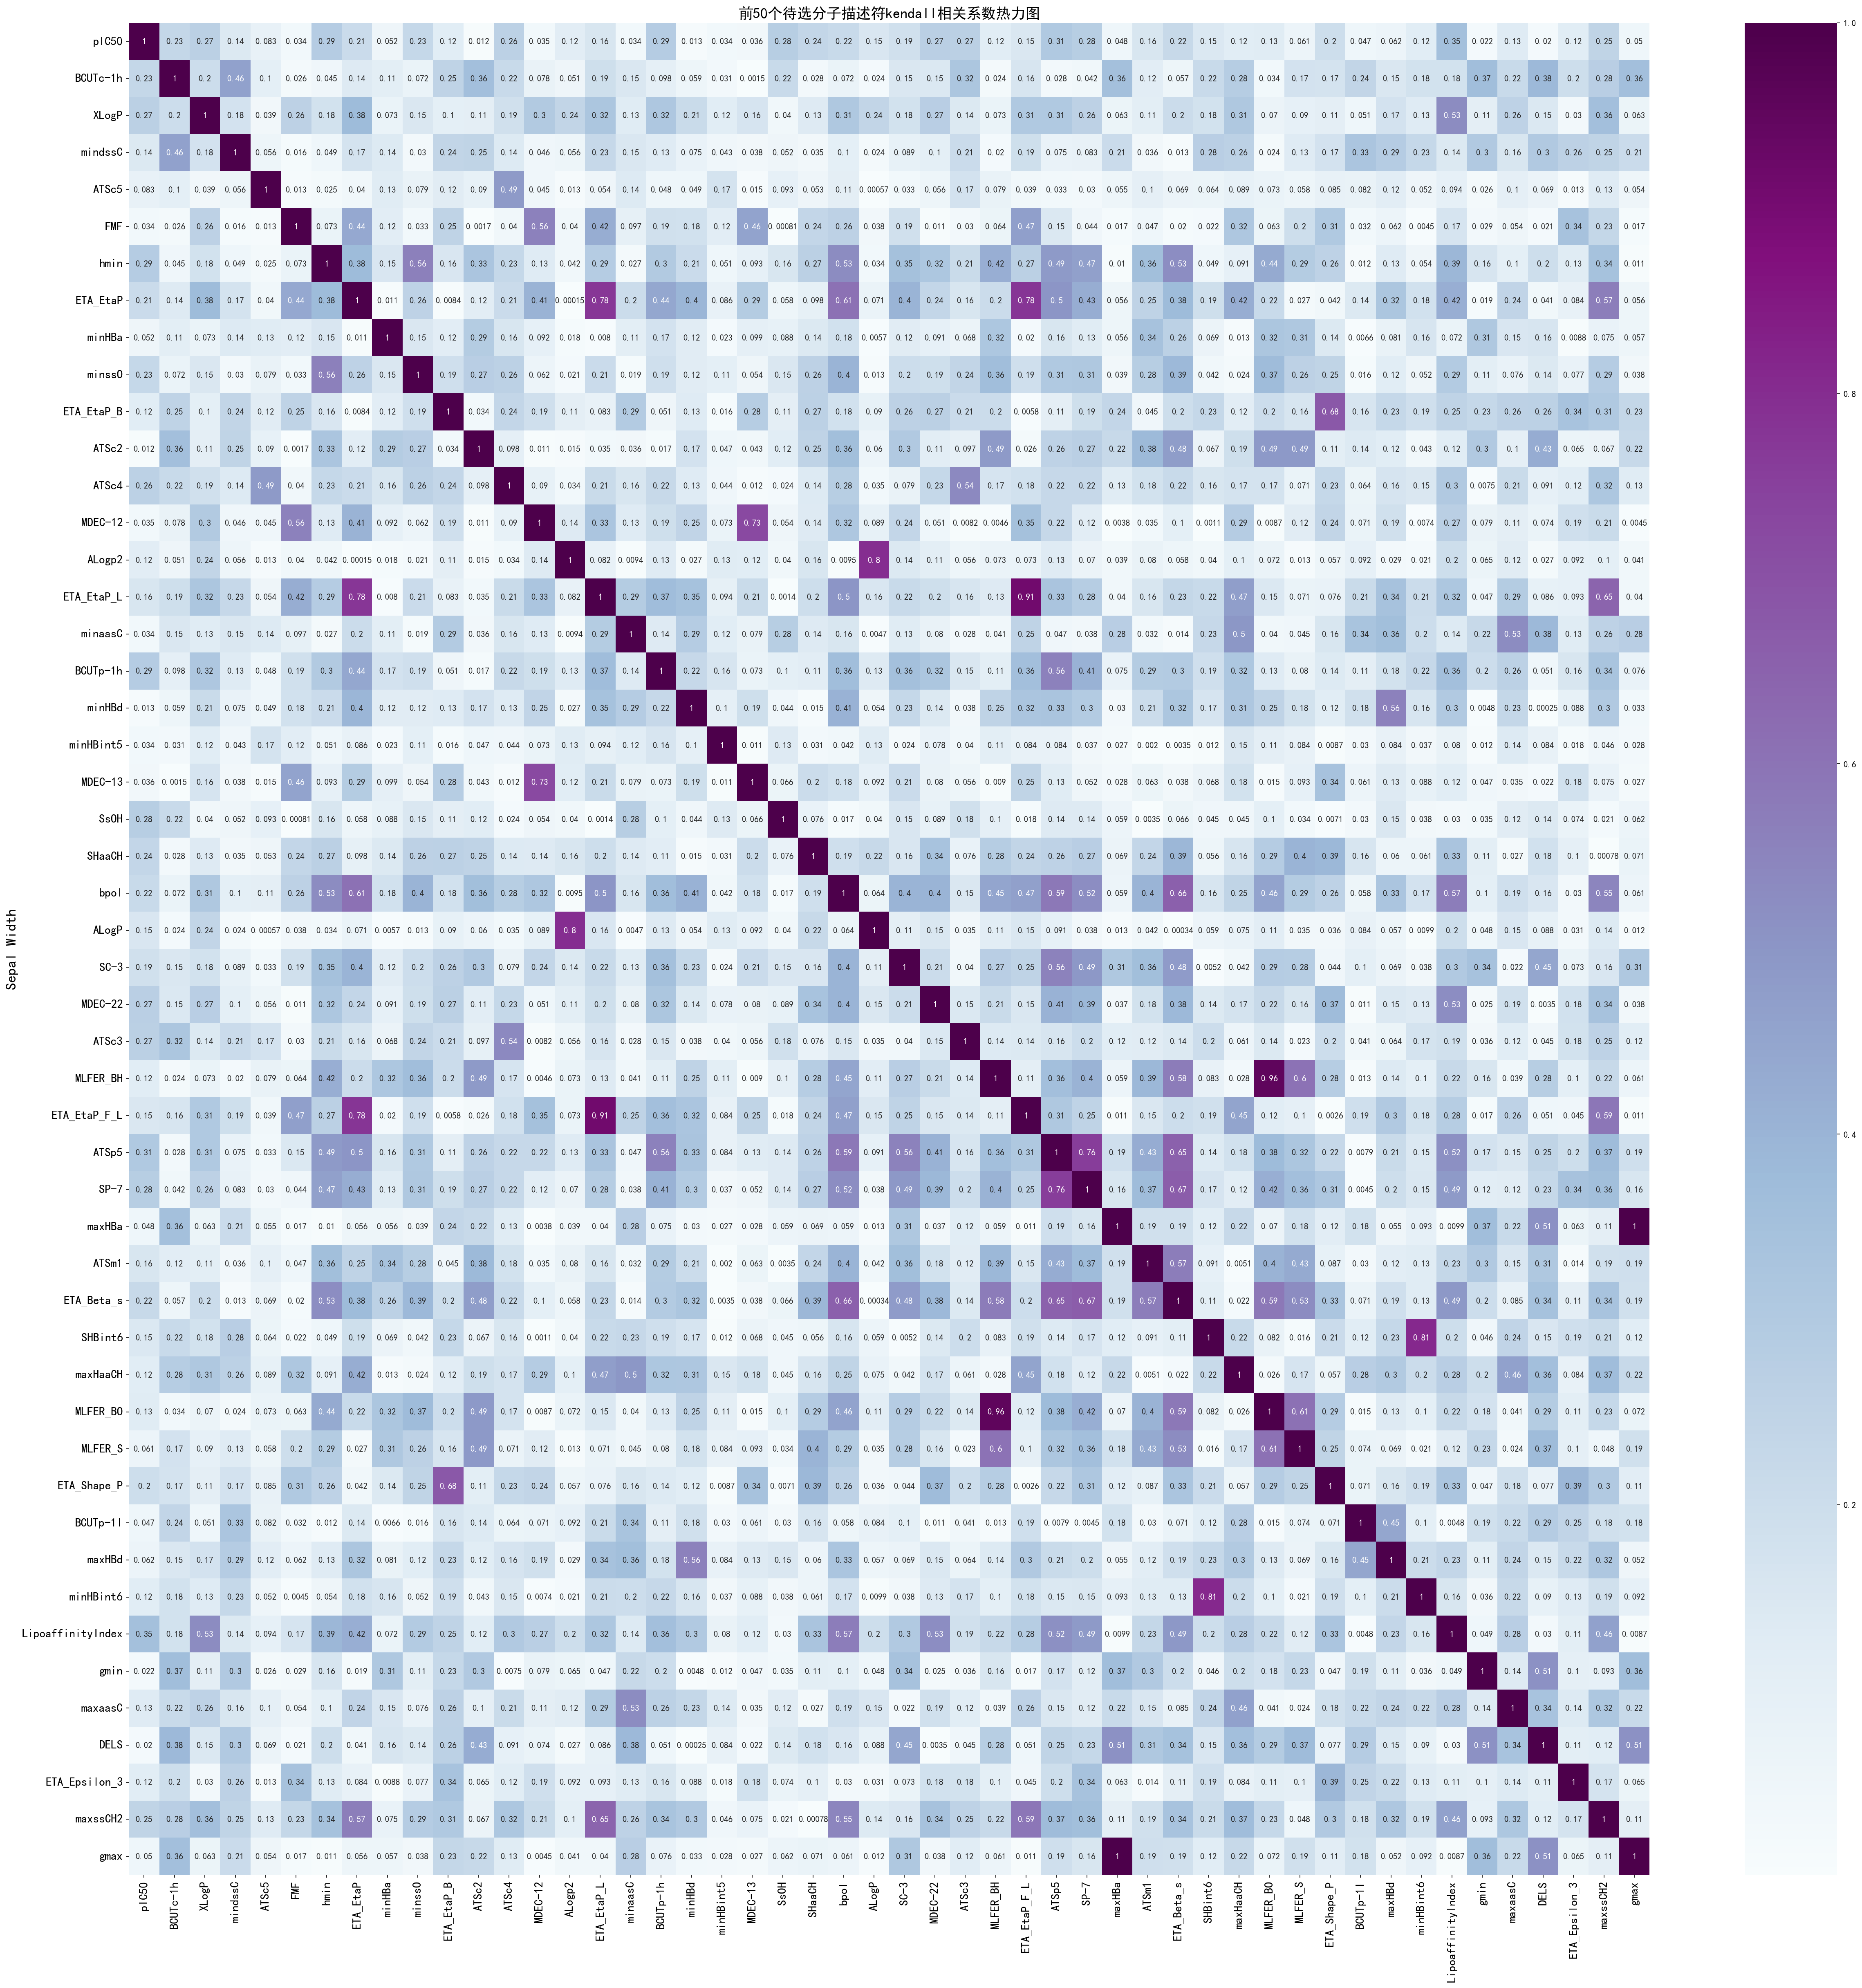

<Figure size 900x600 with 0 Axes>

In [81]:
# 待选特征kendall相关系数矩阵热力图
plt.figure(figsize = (40,40))
ax = sns.heatmap(pd.DataFrame(np.abs(temp_data_std_corr.values[:50, :50])), xticklabels=temp_data_std_corr.columns[:50], yticklabels=temp_data_std_corr.columns[:50], annot=True, cmap="BuPu")

# 设置x\y轴字体大小
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.title("前50个待选分子描述符kendall相关系数热力图", fontsize="xx-large")

# 设置y轴标签
plt.ylabel("Sepal Width", fontsize="xx-large")
plt.xlabel
# 显示图片
plt.show()
"""
    # 选择的分子描述符以下：
    BCUTc-1h, XLogP, ATSc5, FMF, hmin, minHBa, ETA_EtaP_B, ATSc2, ALogp2, minaasC, minHBint5, 
    SsOH, SHaaCH, SC-3, MDEC-22, maxHBa, SHBint6, BCUTp-1l, gmin, ETA_Epsilon_3, 
"""
plt.savefig('../resources/前50个待选分子描述符kendall相关系数热力图.png')

In [89]:
choosed_columns = ['BCUTc-1h', 'XLogP', 'ATSc5', 'FMF', 'hmin', 'minHBa', 'ETA_EtaP_B', 'ATSc2', 'ALogp2', 'minaasC', 'minHBint5', 
    'SsOH', 'SHaaCH', 'SC-3', 'MDEC-22', 'maxHBa', 'SHBint6', 'BCUTp-1l', 'gmin', 'ETA_Epsilon_3']
temp_data[['pIC50']+choosed_columns].to_csv('../data/20features_pIC50.csv')

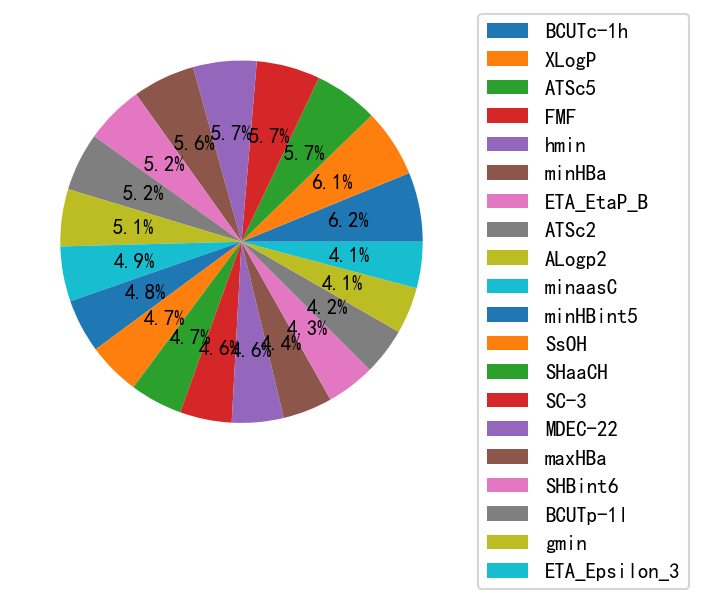

In [107]:
temp_dict = {data_descriptor_final.columns[1:][indices][i]:forest.feature_importances_[indices][i] for i in range(len(forest.feature_importances_))}
temp_list = [temp_dict[column] for column in choosed_columns]
# 绘制饼图描述所选20个分子描述符对pIC50的贡献度
plt.figure(facecolor='white')
plt.pie(temp_list, autopct='%2.1f%%')
plt.legend(choosed_columns, bbox_to_anchor=(1,1.025))
plt.show()